<a href="https://colab.research.google.com/github/LucaSamore/Stroke-Prediction-Analysis/blob/main/stroke_prediction_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predizione di ictus in base ai dati di un paziente
**Progetto di Programmazione di Applicazioni Data Intensive a.a 2022/23**

Luca Samorè

luca.samore@studio.unibo.it

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Introduzione
Nel presente progetto vengono analizzati vari modelli di classificazione per prevedere quanto è probabile che un paziente venga colpito da un ictus. Il dataset, ottenuto da [Kaggle](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset), contiene oltre 5000 record di pazienti, alcuni dei quali sono stati colpiti da tale evento neurologico. L’obiettivo, dunque, è quello di prevedere una variabile discreta binaria.


In [37]:
dataset = pd.read_csv("healthcare-dataset-stroke-data.csv", sep=",")

## Analisi delle feature

In [38]:
dataset.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


**Variabili categoriche**
- `gender`: sesso del paziente
  - "Male"
  - "Female"
  - "Other"
- `work_type`: tipologia di impiego del paziente
  - "children"
  - "Govt_jov"
  - "Never_worked"
  - "Private"
  - "Self-employed"
- `Residence_type`: tipologia di residenza del paziente
  - "Rural"
  - "Urban"
- `smoking_status`: stato di fumatore
  - "formerly smoked"
  - "never smoked"
  - "smokes"
  - "Unknown"
- `ever_married`: "Yes" se il paziente è mai stato sposato, "No" altrimenti
- `hypertension`: 1 se il paziente è affetto da ipertensione, 0 altrimenti
- `heart_disease`: 1 se il paziente ha complicanze cardiache, 0 altrimenti
- `stroke`: 1 se il paziente è stato colpito da ictus, 0 altrimenti

**Variabili numeriche**
- `id`: identificatore univoco del paziente
- `age`: età del paziente
- `avg_glucose_level`: livello medio di glucosio nel sangue
- `bmi`: indice di massa corporea

La variabile target è `stroke` che vale 1 se il paziente è stato colpito da ictus, 0 altrimenti.


In [39]:
dataset.info(memory_usage="deep");

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 1.8 MB


Siccome alcune variabili categoriche sono di tipo object (`gender`, `ever_married`, `work_type`, `Residence_type`, `smoking_status`), per consumare meno memoria, ricarichiamo il dataset modificando il loro tipo come categorico.

In [40]:
categorical_features = ["gender", "ever_married", "work_type", "Residence_type", "smoking_status"]

In [41]:
dataset = pd.read_csv("healthcare-dataset-stroke-data.csv", sep=",", dtype={c: "category" for c in categorical_features})

In [42]:
dataset.info(memory_usage="deep");

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   id                 5110 non-null   int64   
 1   gender             5110 non-null   category
 2   age                5110 non-null   float64 
 3   hypertension       5110 non-null   int64   
 4   heart_disease      5110 non-null   int64   
 5   ever_married       5110 non-null   category
 6   work_type          5110 non-null   category
 7   Residence_type     5110 non-null   category
 8   avg_glucose_level  5110 non-null   float64 
 9   bmi                4909 non-null   float64 
 10  smoking_status     5110 non-null   category
 11  stroke             5110 non-null   int64   
dtypes: category(5), float64(3), int64(4)
memory usage: 306.2 KB


Notiamo che il consumo di memoria è stato ridotto significativamente.

La colonna `id` contiene un identificatore univoco per ogni paziente. Essa è irrilevante ai fini della predizione, perciò la possiamo eliminare o utilizzare come indice del dataframe. Procediamo con la seconda soluzione.

In [43]:
dataset.set_index('id', inplace=True)
dataset.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## Analisi esplorativa e pulizia dei dati


Prima di vedere qualche statistica sui dati, verifichiamo la presenza di valori nulli all’interno del dataset.

In [44]:
dataset.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

Notiamo che sono presenti 201 istanze in cui la feature `bmi` è NaN. Procediamo rimuovendo tali record.

In [45]:
dataset.dropna(inplace=True)
dataset.isna().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

Per ogni variabile numerica, visualizziamo alcune statistiche, come media, minimo, massimo, deviazione standard e percentili.

In [70]:
dataset.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,4909.000000,4909.000000,4909.000000,4909.000000,4909.000000,4909.000000
mean,42.865374,0.091872,0.049501,105.305150,28.893237,0.042575
std,22.555115,0.288875,0.216934,44.424341,7.854067,0.201917
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.070000,23.500000,0.000000
50%,44.000000,0.000000,0.000000,91.680000,28.100000,0.000000
75%,60.000000,0.000000,0.000000,113.570000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


Notiamo che la media dei pazienti colpiti da ictus è molto bassa. Tale osservazione ci fa pensare che le classi sono molto sbilanciate.

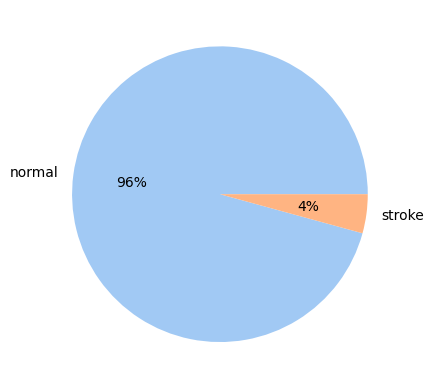

In [55]:
plt.pie(
    dataset['stroke'].value_counts(),
    labels=['normal', 'stroke'],
    colors=sns.color_palette('pastel'),
    autopct='%.0f%%'
);

Come potevamo aspettarci, le classi sono fortemente sbilanciate. Nella sezione successiva utilizzeremo delle tecniche apposite per affrontare questo problema.